In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
import compute_S_rate
import auxiliary_functions
import seaborn
import math

import networkx as nx

import auxiliary_functions

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
sbm = auxiliary_functions.stochastic_block_model(num_blocks=3, block_sizes=[50, 500, 1000], p_within_block=0.03, q_between_blocks=0.001)
sbm_adj = nx.adjacency_matrix(sbm)

In [3]:
T = auxiliary_functions.Discrete_RW_T(sbm_adj)
times = [1, 2, 3, 5, 8, 10, 15, 20, 25, 35]

In [4]:
list_powerT = []
for t in times:
    power_T = np.linalg.matrix_power(T, t)
    list_powerT.append(power_T)


(array([ 46.,  73., 229., 188., 145., 322., 330., 178.,  32.,   7.]),
 array([0.        , 0.00013249, 0.00026497, 0.00039746, 0.00052995,
        0.00066244, 0.00079492, 0.00092741, 0.0010599 , 0.00119238,
        0.00132487]),
 <BarContainer object of 10 artists>)

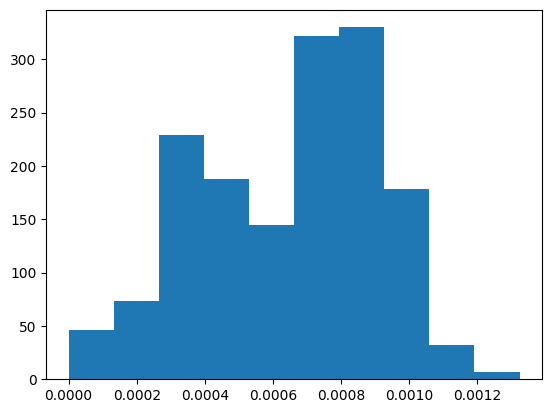

In [5]:
plt.hist(list_powerT[-1][0])

In [6]:
n_edges = sbm_adj.toarray().sum() / 2
degrees = sbm_adj.toarray().sum(0)
pi_0 = degrees / (2*n_edges)

list_H_sbm = [0]
list_rows_entropies = []
for t in times:
    power_T = np.linalg.matrix_power(T, t)
    logpowTdata = np.log(np.where(power_T > 0, power_T, 1))
    powTlogpowTdata = power_T * logpowTdata
    rows_entropies = -np.sum(powTlogpowTdata, axis=1)
    list_rows_entropies.append(rows_entropies)
    H_sbm = np.dot(pi_0, rows_entropies)
    print(H_sbm)
    list_H_sbm.append(H_sbm)

3.2935018701258065
6.030449063534942
6.844703981074531
7.045635977328593
7.128943355598409
7.163844670040552
7.216160023526213
7.2416761440809285
7.254380872649986
7.263913565232783


In [7]:
purple = "#5e2b97"
green = "#009688"
brown = "#C77025"
orange = "#FFA500"

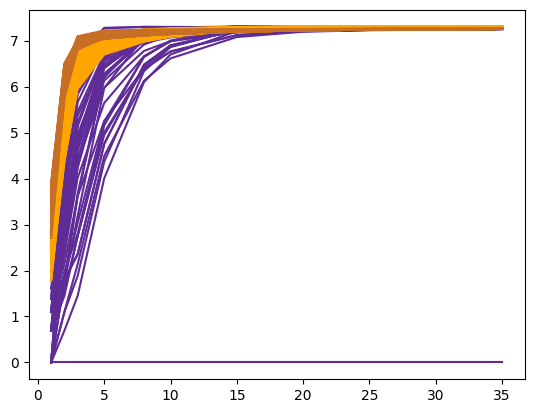

In [8]:
rows = np.array(list_rows_entropies)

colours = [purple]*50 + [orange]*500 + [brown]*1000
fig, ax = plt.subplots(1,1)
ax.plot(times, rows)
for i,line in enumerate(ax.lines):
    line.set_color(colours[i])
    
plt.show()

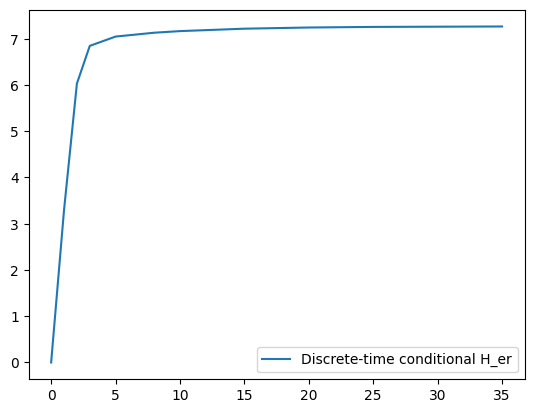

In [9]:
plt.plot([0] + times, list_H_sbm, label = 'Discrete-time conditional H_er')
#plt.plot(range(len(list_model_entropies)), list_model_entropies, label = 'model conditional H')
#plt.plot([0] + times[:-1], H_er_rw[list(H_er_rw.keys())[0]], label = 'Continuous-time conditional H_er')
plt.legend()
#plt.savefig('/home/b/skoove/Desktop/plots_entropy/conditional_entropyER.png', format='png', dpi=300)
plt.show()

## Continuous Time

In [19]:
times_long = [1, 2, 3, 5, 8, 10, 15, 20, 25, 35, 1000]

In [20]:
lamdas = [0.01, 0.1, 1]

sbm_rw = StaticTempNetwork(times = times_long, adjacency = csr_matrix(sbm_adj))
sbm_rw.compute_laplacian_matrices(random_walk = True)

for lamda in lamdas:
    sbm_rw.compute_inter_transition_matrices(lamda, dense_expm=False, use_sparse_stoch=False)
    sbm_rw.compute_transition_matrices(lamda)

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

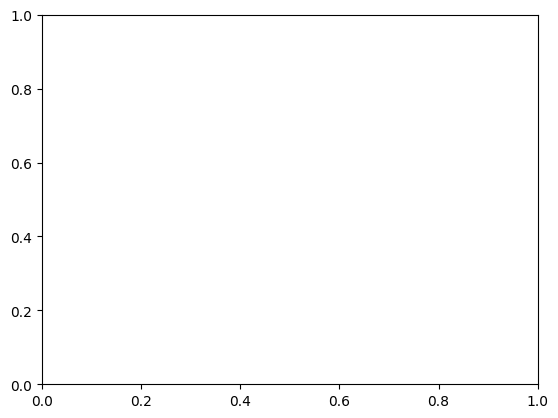

In [21]:
for lamda in lamdas:
    H_er_rw = compute_S_rate.compute_conditional_entropy(net=sbm_rw, list_T=sbm_rw.T[lamda], lamda=lamda, force_csr=True, time_domain= list(range(len(times)-1)), p0 = pi_0)
    plt.plot([0] + times_long[:-1], H_er_rw[list(H_er_rw.keys())[0]], label = str(lamda))

plt.legend()
plt.show()

### Rows entropies continuous-time

In [12]:
# i implement it here directly, so that i don't need to modify the compute_S_rate file
rows_conditional_S = {}

time_domain= list(range(len(times_long)-1))
k_range = range(len(time_domain))
p0 = pi_0

for lamda in lamdas:
    list_T = sbm_rw.T[lamda]
    rows_conditional_S_t = []
    #One entropy value for each Transition Matrix
    for k in k_range:
        T = list_T[time_domain[k]].tocsr()
        #p = p0 @ T
        logTdata = np.log(np.where(T.data > 0, T.data, 1))
        TlogTdata = T.data * logTdata
        # there shouldn't be need for this
        # TlogT[TlogT>0]=0
        TlogT = csr_matrix((TlogTdata, T.indices, T.indptr), shape=T.shape)
        rows_conditional_S_t.append(-p0 @ TlogT)
    rows_conditional_S[f'{lamda:.11f}'] = rows_conditional_S_t

In [17]:
list_rows_entropies = rows_conditional_S[list(rows_conditional_S.keys())[2]]
#rows = np.array(list_rows_entropies)
print(rows.shape)

(9, 1550)


In [18]:
[np.sum(i) for i in list_rows_entropies]

[3.9340800770655067,
 5.699568486756757,
 6.840736044782313,
 7.09547267824056,
 7.141608787918806,
 7.204294242099347,
 7.235056619648352,
 7.250683015413029,
 7.262786614641]

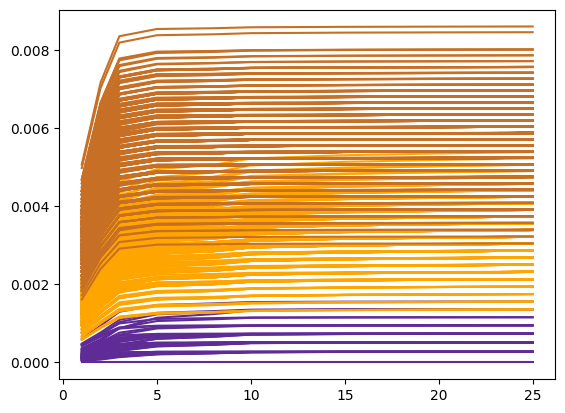

In [15]:
list_rows_entropies = rows_conditional_S[list(rows_conditional_S.keys())[2]]
rows = np.array(list_rows_entropies)

colours = [purple]*50 + [orange]*500 + [brown]*1000
fig, ax = plt.subplots(1,1)
ax.plot(times_long[:-1], rows)
for i,line in enumerate(ax.lines):
    line.set_color(colours[i])
    
plt.show()

In [16]:
len(rows_conditional_S[list(rows_conditional_S.keys())[0]])

9